# Panorama da desigualdade de gênero no mercado de Inteligência Artificial no Brasil

## Prof. Dr. Neylson Crepalde

In [281]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.tools import add_constant
from statsmodels.graphics.factorplots import interaction_plot
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Dar um merge de linhas nos dois bancos...
sud = pd.concat([
    pd.read_csv("../data/rais_mg_es_rj.csv", sep='\t', decimal=',', na_values=["{ñ class}", "{ñclass}"]),
    pd.read_csv("../data/rais_sp.csv", sep='\t', decimal=',', na_values=["{ñ class}", "{ñclass}"])
], axis=0)

C:\Users\Neylson\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Filtra apenas salário mensal
sud = sud.loc[sud["Tipo Salário"] == 1, :]

In [4]:
# Filçtra apenas trabalhos não parciais
sud = sud.loc[sud["Ind Trab Parcial"] == 0, :]

In [5]:
# Corrige grau de escolaridade para obter valor 0
sud['Escolaridade após 2005'] -= 1

In [6]:
print(sud['Escolaridade após 2005'].unique())
sud['Escolaridade após 2005'].value_counts()

[ 0  1  3  4  5  6  7  8  9 10  2]


8     177215
6      40281
7      24173
9       2967
5       2409
4       1522
10       444
3        393
2        202
1        201
0         13
Name: Escolaridade após 2005, dtype: int64

In [7]:
# Coloca label em sexo
sud.loc[sud['Sexo Trabalhador'] == 1, 'Sexo Trabalhador'] = "Masculino"
sud.loc[sud['Sexo Trabalhador'] == 2, 'Sexo Trabalhador'] = "Feminino"

In [8]:
sud['Sexo Trabalhador'].value_counts()

Masculino    166632
Feminino      83188
Name: Sexo Trabalhador, dtype: int64

In [9]:
# Filtra apenas quem Raça Cor não é 99
sud = sud.loc[sud["Raça Cor"] != 99,:]

In [10]:
# Coloca label em raça
sud.loc[sud["Raça Cor"] == 1, 'Raça Cor'] = "Indígena"
sud.loc[sud["Raça Cor"] == 2, 'Raça Cor'] = "Branca"
sud.loc[sud["Raça Cor"] == 4, 'Raça Cor'] = "Preta"
sud.loc[sud["Raça Cor"] == 6, 'Raça Cor'] = "Amarela"
sud.loc[sud["Raça Cor"] == 8, 'Raça Cor'] = "Parda"
sud.loc[sud["Raça Cor"] == 9, 'Raça Cor'] = "Não identificada"

In [11]:
sud['Raça Cor'].value_counts()

Branca              159556
Parda                54080
Não identificada     21159
Preta                10504
Amarela               3829
Indígena               687
Name: Raça Cor, dtype: int64

In [12]:
sud['Brasileiro'] = sud['Nacionalidade'].apply(lambda x: 1 if (x == 10) else 0)

In [13]:
sud.Brasileiro.value_counts()

1    247948
0      1867
Name: Brasileiro, dtype: int64

Muito pouco estrangeiro trabalhando na área. Talvez não seja uma variável interessante para modelar.

In [14]:
sud.groupby("Brasileiro").agg({"Vl Remun Média Nom": "median"})

,Vl Remun Média Nom
Brasileiro,
0,6977.45
1,3571.28


Mas a diferença salarial é gritante! Investiguemos.

In [15]:
sud['Tempo Emprego']

0           1.0
1           2.9
2           7.7
3           2.9
4           2.9
          ...  
180452     35.9
180453    377.3
180454    378.9
180455    147.9
180456      6.4
Name: Tempo Emprego, Length: 249815, dtype: float64

In [16]:
sud.shape

(249815, 63)

In [17]:
sud.columns

Index(['Bairros SP', 'Bairros Fortaleza', 'Bairros RJ', 'Causa Afastamento 1',
       'Causa Afastamento 2', 'Causa Afastamento 3', 'Motivo Desligamento',
       'CBO Ocupação 2002', 'CNAE 2.0 Classe', 'CNAE 95 Classe',
       'Distritos SP', 'Vínculo Ativo 31/12', 'Faixa Etária',
       'Faixa Hora Contrat', 'Faixa Remun Dezem (SM)',
       'Faixa Remun Média (SM)', 'Faixa Tempo Emprego',
       'Escolaridade após 2005', 'Qtd Hora Contr', 'Idade',
       'Ind CEI Vinculado', 'Ind Simples', 'Mês Admissão', 'Mês Desligamento',
       'Mun Trab', 'Município', 'Nacionalidade', 'Natureza Jurídica',
       'Ind Portador Defic', 'Qtd Dias Afastamento', 'Raça Cor',
       'Regiões Adm DF', 'Vl Remun Dezembro Nom', 'Vl Remun Dezembro (SM)',
       'Vl Remun Média Nom', 'Vl Remun Média (SM)', 'CNAE 2.0 Subclasse',
       'Sexo Trabalhador', 'Tamanho Estabelecimento', 'Tempo Emprego',
       'Tipo Admissão', 'Tipo Estab', 'Tipo Estab.1', 'Tipo Defic',
       'Tipo Vínculo', 'IBGE Subsetor', 'Vl 

#### Variáveis de interesse para trabalhar

- Sexo Trabalhador
- Idade
- Qtd Hora Contrat
- Escolaridade após 2005
- Município
- Nacionalidade
- Ind Portador Defic
- Raça Cor
- Vl Remun Dezembro Nom
- Vl Remun Média Nom
- Tamanho Estabelecimento
- Tempo Emprego (em meses)
- Ind Portador Defic
- Brasileiro

Verificar as categorias das variáveis e implementar cosntrução de labels.

---

# Análise Exploratória de Dados

## Sexo

Existem diferenças significativas nas principais variáveis elencadas por sexo?

Masculino    166628
Feminino      83187
Name: Sexo Trabalhador, dtype: int64
Masculino    66.7
Feminino     33.3
Name: Sexo Trabalhador, dtype: float64


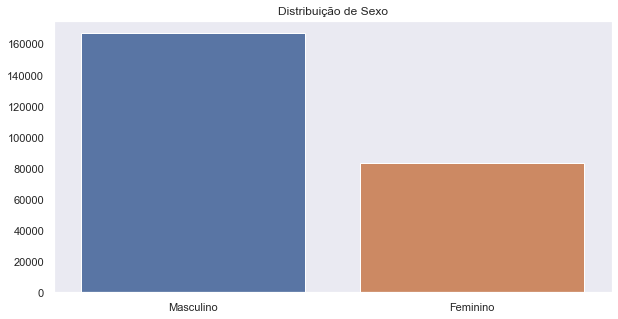

In [18]:
print(sud['Sexo Trabalhador'].value_counts())
print(((sud['Sexo Trabalhador'].value_counts() / sud.shape[0] )*100).round(2))

# Gráfico
sns.set(style="dark")

plt.figure(figsize=(10,5))
sns.countplot("Sexo Trabalhador", data=sud)
plt.title("Distribuição de Sexo")
plt.ylabel("")
plt.xlabel("")
plt.xticks([0,1],["Masculino", "Feminino"])
plt.show()

## Idade

In [167]:
sud.Idade.describe()

count    249815.000000
mean         33.857763
std           9.628421
min          14.000000
25%          27.000000
50%          32.000000
75%          39.000000
max          99.000000
Name: Idade, dtype: float64

In [27]:
sud.groupby("Sexo Trabalhador").agg({"Idade": "mean"})

,Idade
Sexo Trabalhador,
Feminino,33.558837
Masculino,34.006998


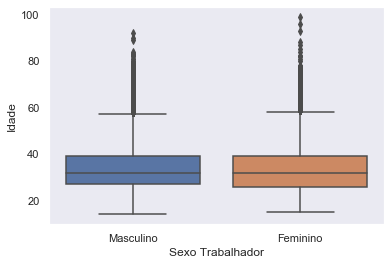

In [20]:
sns.boxplot(x="Sexo Trabalhador", y="Idade", data=sud)
plt.show()

In [45]:
stats.ttest_ind(sud.loc[sud["Sexo Trabalhador"] == "Masculino","Idade"], sud.loc[sud["Sexo Trabalhador"] == "Feminino","Idade"])

Ttest_indResult(statistic=10.96666135910969, pvalue=5.609503711010635e-28)

Embora o teste T tenha dado significativo, há razões para desconfiar que o baixo p-valor se deve apenas ao fato de o $n$ ser enorme. Se o $n$ fosse menor, provavelmente essas diferenças não seriam significativas. Vamos testar com 5 mil casos aleatórios e bootstrap.

In [71]:
pvalores = []
for i in range(1000):
    res = stats.ttest_ind(sud.loc[sud["Sexo Trabalhador"] == "Masculino","Idade"].sample(n=10000), 
                          sud.loc[sud["Sexo Trabalhador"] == "Feminino","Idade"].sample(n=5000))
    pvalores.append(res.pvalue)
print("Média dos p-valores: ", np.mean(pvalores).round(4))

Média dos p-valores:  0.052


## Raça Cor

In [25]:
t = pd.crosstab(sud['Sexo Trabalhador'], sud['Raça Cor'])
t.apply(lambda r: (r/r.sum()*100), axis=1)

Raça Cor,Amarela,Branca,Indígena,Não identificada,Parda,Preta
Sexo Trabalhador,,,,,,
Feminino,1.606020,63.428180,0.293315,8.492914,21.581497,4.598074
Masculino,1.496147,64.090069,0.265862,8.458362,21.681230,4.008330


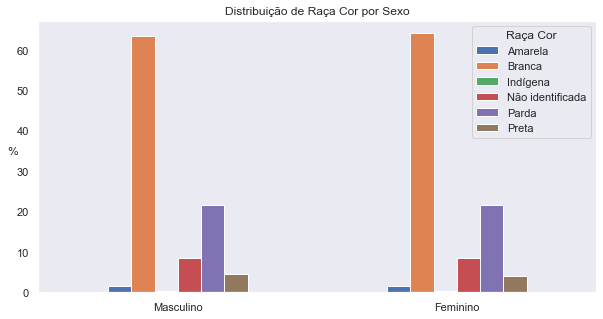

In [22]:
t.apply(lambda r: (r/r.sum()*100), axis=1).plot(kind="bar", figsize=(10,5))
plt.xticks([0,1], ['Masculino', 'Feminino'], rotation=0)
plt.xlabel("")
plt.ylabel("%", rotation=0)
plt.title("Distribuição de Raça Cor por Sexo")
plt.show()

In [64]:
print(t)
stats.chi2_contingency(t)

Raça Cor          Amarela  Branca  Indígena  Não identificada  Parda  Preta
Sexo Trabalhador                                                           
Feminino             1336   52764       244              7065  17953   3825
Masculino            2493  106792       443             14094  36127   6679


(55.92609721310422,
 8.416363645985641e-11,
 5,
 array([[  1275.03561836,  53131.25701819,    228.7671637 ,
           7045.82884535,  18008.33801013,   3497.77334427],
        [  2553.96438164, 106424.74298181,    458.2328363 ,
          14113.17115465,  36071.66198987,   7006.22665573]]))

Muito embora o teste $\chi^2$ tenha dado significativo, ao observamos a tabela de valores observados e os valores esperados abaixo, vemos que eles estão bastante próximos. Poderíamos indagar se o $n$ fosse menor, esses valores não seriam significativos. Provavelmente não...

In [72]:
pvalores_chi2 = []
for i in range(1000):
    subamostra = sud.sample(5000)
    t1 = pd.crosstab(subamostra['Sexo Trabalhador'], subamostra['Raça Cor'])
    pvalores_chi2.append(stats.chi2_contingency(t1)[1])
print("Média de p-valores chi2 para sexo e raça:", np.mean(pvalores_chi2).round(4))

Média de p-valores chi2 para sexo e raça: 0.4261


Utilizando bootstrap, o $\chi^2$ não fica significativo.

---

In [69]:
sud.groupby("Sexo Trabalhador").agg({"Vl Remun Média Nom": "median", 
                                     "Qtd Hora Contr": "mean",
                                     "Escolaridade após 2005": "mean",
                                     "Tempo Emprego": "median"
                                    })

,Vl Remun Média Nom,Qtd Hora Contr,Escolaridade após 2005,Tempo Emprego
Sexo Trabalhador,,,,
Feminino,2727.070,39.459026,7.388077,17.3
Masculino,4128.185,39.949582,7.592031,17.4


In [75]:
stats.ttest_ind(sud.loc[sud["Sexo Trabalhador"] == "Masculino","Qtd Hora Contr"],
                        sud.loc[sud["Sexo Trabalhador"] == "Feminino","Qtd Hora Contr"])

Ttest_indResult(statistic=24.0160674960307, pvalue=2.6376067677565002e-127)

In [78]:
# Testa diferenças nas horas de contrato usando bootstrap
pvalores_qtdhoracont = []
for i in range(1000):
    res = stats.ttest_ind(sud.loc[sud["Sexo Trabalhador"] == "Masculino","Qtd Hora Contr"].sample(n=10000),
                          sud.loc[sud["Sexo Trabalhador"] == "Feminino","Qtd Hora Contr"].sample(n=5000))
    pvalores_qtdhoracont.append(res.pvalue)
print("Média dos p-valores para Qtd Hora Contr:", np.mean(pvalores_qtdhoracont).round(4))

Média dos p-valores para Qtd Hora Contr: 0.0


In [79]:
# Testa diferenças de escolaridade usando bootstrap
pvalores_esco = []
for i in range(1000):
    res = stats.ttest_ind(sud.loc[sud["Sexo Trabalhador"] == "Masculino","Escolaridade após 2005"].sample(n=10000),
                          sud.loc[sud["Sexo Trabalhador"] == "Feminino","Escolaridade após 2005"].sample(n=5000))
    pvalores_esco.append(res.pvalue)
print("Média dos p-valores para Escolaridade:", np.mean(pvalores_esco).round(4))

Média dos p-valores para Escolaridade: 0.0


In [80]:
# Testa diferenças de tempo de emprego usando bootstrap
pvalores_tempoemprego = []
for i in range(1000):
    res = stats.ttest_ind(sud.loc[sud["Sexo Trabalhador"] == "Masculino","Tempo Emprego"].sample(n=10000),
                          sud.loc[sud["Sexo Trabalhador"] == "Feminino","Tempo Emprego"].sample(n=5000))
    pvalores_tempoemprego.append(res.pvalue)
print("Média dos p-valores para Tempo de Emprego:", np.mean(pvalores_tempoemprego).round(4))

Média dos p-valores para Tempo de Emprego: 0.0413


In [81]:
# Testa diferenças de salário usando bootstrap
pvalores_sal = []
for i in range(1000):
    res = stats.ttest_ind(sud.loc[sud["Sexo Trabalhador"] == "Masculino","Vl Remun Média Nom"].sample(n=10000),
                          sud.loc[sud["Sexo Trabalhador"] == "Feminino","Vl Remun Média Nom"].sample(n=5000))
    pvalores_sal.append(res.pvalue)
print("Média dos p-valores para Salário médio:", np.mean(pvalores_sal).round(4))

Média dos p-valores para Salário médio: 0.0


É possível afirmar que as mulheres trabalham sistematicamente menos, possuem escolaridade mais baixa, tem menos tempo de emprego em seus trabalhos e possuem salário sistematicamente menor.

In [23]:
sud.groupby("Sexo Trabalhador").agg({"Vl Remun Média Nom": "mean"})

,Vl Remun Média Nom
Sexo Trabalhador,
Feminino,4489.264065
Masculino,6233.341422


---

# Investigando a diferença de salário

In [96]:
sud['salario'] = sud['Vl Remun Média Nom'] + 0.01

(array([  750.,  3899., 48057., 61089., 56263., 47864., 21416.,  5815.,
         1443.,   152.]),
 array([ 5.66164016,  6.27073136,  6.87982255,  7.48891375,  8.09800494,
         8.70709613,  9.31618733,  9.92527852, 10.53436971, 11.14346091,
        11.7525521 ]),
 <a list of 10 Patch objects>)

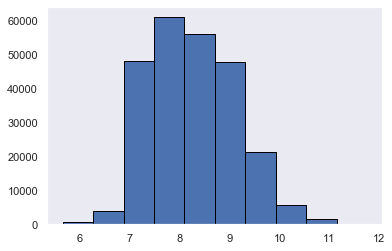

In [98]:
plt.hist(np.log(sud.loc[sud["Vl Remun Média Nom"] > 0,'Vl Remun Média Nom']), edgecolor="black")

(array([  3067.,      0.,      0.,      0.,      0.,      0.,   3820.,
        145304.,  92957.,   4667.]),
 array([-4.60517019, -2.96939795, -1.33362571,  0.30214652,  1.93791876,
         3.573691  ,  5.20946323,  6.84523547,  8.48100771, 10.11677994,
        11.75255218]),
 <a list of 10 Patch objects>)

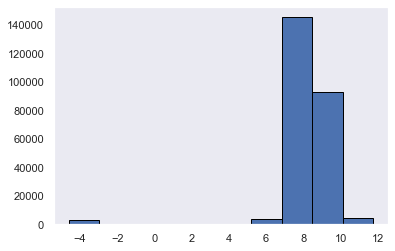

In [104]:
plt.hist(np.log(sud.salario), edgecolor="black")

Vamos modelar apenas as pessoas que recebem algum tipo de salário.

In [105]:
sud.loc[sud['Vl Remun Média Nom'] > 0,:].groupby("Sexo Trabalhador").agg({"Vl Remun Média Nom": "mean"})

,Vl Remun Média Nom
Sexo Trabalhador,
Feminino,4554.748812
Masculino,6304.127985


In [107]:
sum(sud['Vl Remun Média Nom'] == 0)

3067

Não há muita diferença na média contendo quem tem salário zerado. De fato, quem tem salário zero são 3067 pessoas.

Vamos filtrar apenas pessoas entre 18 e 80 anos.

In [261]:
bd = sud.loc[(sud['Vl Remun Média Nom'] > 0) & 
             (sud['Idade'] > 17) & (sud['Idade'] < 81)
             ,:]

In [263]:
# Qual é a idade média do recorte selecionado?
np.mean(bd.Idade)

33.83107710417893

In [262]:
bd['idadecent'] = bd.Idade - np.mean(bd.Idade)
bd['Idade_quad'] = bd.idadecent ** 2

C:\Users\Neylson\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Neylson\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [264]:
# Cria dummy branco
bd["Branco"] = bd['Raça Cor'].apply(lambda x: 1 if x in ['Branca', 'Amarela'] else 0)

C:\Users\Neylson\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [265]:
pd.crosstab(bd.Branco, bd["Raça Cor"])

Raça Cor,Amarela,Branca,Indígena,Não identificada,Parda,Preta
Branco,,,,,,
0,0,0,676,20862,53332,10338
1,3800,157347,0,0,0,0


In [266]:
bd.columns

Index(['Bairros SP', 'Bairros Fortaleza', 'Bairros RJ', 'Causa Afastamento 1',
       'Causa Afastamento 2', 'Causa Afastamento 3', 'Motivo Desligamento',
       'CBO Ocupação 2002', 'CNAE 2.0 Classe', 'CNAE 95 Classe',
       'Distritos SP', 'Vínculo Ativo 31/12', 'Faixa Etária',
       'Faixa Hora Contrat', 'Faixa Remun Dezem (SM)',
       'Faixa Remun Média (SM)', 'Faixa Tempo Emprego',
       'Escolaridade após 2005', 'Qtd Hora Contr', 'Idade',
       'Ind CEI Vinculado', 'Ind Simples', 'Mês Admissão', 'Mês Desligamento',
       'Mun Trab', 'Município', 'Nacionalidade', 'Natureza Jurídica',
       'Ind Portador Defic', 'Qtd Dias Afastamento', 'Raça Cor',
       'Regiões Adm DF', 'Vl Remun Dezembro Nom', 'Vl Remun Dezembro (SM)',
       'Vl Remun Média Nom', 'Vl Remun Média (SM)', 'CNAE 2.0 Subclasse',
       'Sexo Trabalhador', 'Tamanho Estabelecimento', 'Tempo Emprego',
       'Tipo Admissão', 'Tipo Estab', 'Tipo Estab.1', 'Tipo Defic',
       'Tipo Vínculo', 'IBGE Subsetor', 'Vl 

In [268]:
y = np.log(bd['Vl Remun Média Nom'])
X = pd.get_dummies(bd[['Sexo Trabalhador',
                       'Escolaridade após 2005', 
                       'Qtd Hora Contr', 
                       'idadecent', 'Idade_quad', 
                       'Brasileiro', 
                       'Branco', 
                       'Tempo Emprego'
                      ]],
                  drop_first=True)

In [269]:
X = add_constant(X)
X

C:\Users\Neylson\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,const,Escolaridade após 2005,Qtd Hora Contr,idadecent,Idade_quad,Brasileiro,Branco,Tempo Emprego,Sexo Trabalhador_Masculino
0,1.0,0,44,3.168923,10.042072,1,1,1.0,1
1,1.0,0,40,-3.831077,14.677152,1,0,2.9,1
2,1.0,1,44,6.168923,38.055610,1,0,7.7,1
3,1.0,1,40,-6.831077,46.663614,1,0,2.9,1
4,1.0,1,40,-6.831077,46.663614,1,0,2.9,1
...,...,...,...,...,...,...,...,...,...
180452,1.0,10,40,9.168923,84.069147,1,1,35.9,0
180453,1.0,10,8,26.168923,684.812526,1,1,377.3,0
180454,1.0,10,8,25.168923,633.474680,1,0,378.9,0
180455,1.0,10,8,13.168923,173.420530,1,1,147.9,0


### Teste de multicolinearidade

In [270]:
for col in X.columns:
    print(col + ": ", vif(X.values, X.columns.get_loc(col)))

const:  308.93929290203357
Escolaridade após 2005:  1.0785504010904856
Qtd Hora Contr:  1.2622354622944212
idadecent:  1.7040447028147596
Idade_quad:  1.6562700984501002
Brasileiro:  1.0030666749766268
Branco:  1.0246210517947478
Tempo Emprego:  1.4565388318549866
Sexo Trabalhador_Masculino:  1.0134422418046194


In [271]:
regressao = sm.OLS(y, X).fit()
print(regressao.summary())

                            OLS Regression Results                            
Dep. Variable:     Vl Remun Média Nom   R-squared:                       0.408
Model:                            OLS   Adj. R-squared:                  0.408
Method:                 Least Squares   F-statistic:                 2.119e+04
Date:                Mon, 10 Feb 2020   Prob (F-statistic):               0.00
Time:                        15:48:35   Log-Likelihood:            -2.4426e+05
No. Observations:              246355   AIC:                         4.885e+05
Df Residuals:                  246346   BIC:                         4.886e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [272]:
Xpad = X.apply(stats.zscore)

C:\Users\Neylson\Anaconda3\lib\site-packages\scipy\stats\stats.py:2315: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [273]:
Xpad = Xpad.drop(columns="const")

In [274]:
regpad = sm.OLS(y, Xpad).fit()
print(regpad.summary())

                                 OLS Regression Results                                
Dep. Variable:     Vl Remun Média Nom   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              131.1
Date:                Mon, 10 Feb 2020   Prob (F-statistic):                   1.49e-220
Time:                        15:48:52   Log-Likelihood:                     -8.7068e+05
No. Observations:              246355   AIC:                                  1.741e+06
Df Residuals:                  246347   BIC:                                  1.741e+06
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

---

## Testar

- termo interativo entre sexo e branco
- termo interativo entre sexo e escolaridade
- termo interativo entre sexo e idade (análise do efeito senioridade)

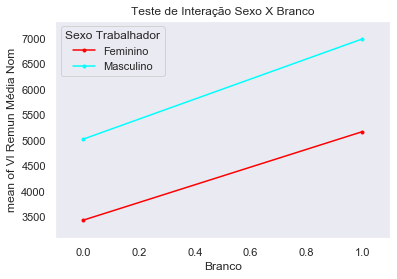

In [284]:
interaction_plot(bd.Branco, bd["Sexo Trabalhador"], bd["Vl Remun Média Nom"])
plt.title("Teste de Interação Sexo X Branco")
plt.show()

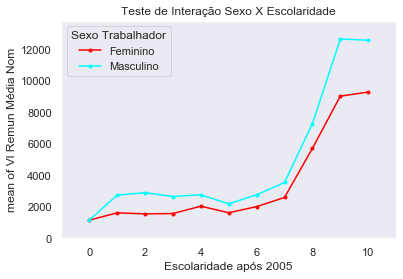

In [285]:
interaction_plot(bd["Escolaridade após 2005"], bd["Sexo Trabalhador"], bd["Vl Remun Média Nom"])
plt.title("Teste de Interação Sexo X Escolaridade")
plt.show()

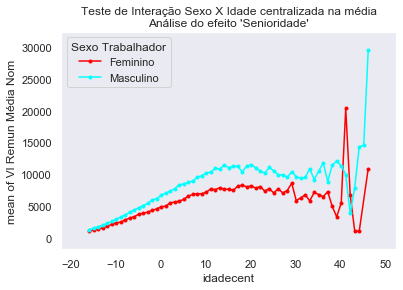

In [287]:
interaction_plot(bd.idadecent, bd["Sexo Trabalhador"], bd["Vl Remun Média Nom"])
plt.title("Teste de Interação Sexo X Idade centralizada na média\nAnálise do efeito 'Senioridade'")
plt.show()

In [280]:
regressao1 = smf.ols(formula="np.log(Vl Remun Média Nom) ~ Sexo Trabalhador + Escolaridade após 2005 +\
                            Qtd Hora Contr + idadecent + Idade_quad + Brasileiro + Branco + Tempo Emprego", data=bd).fit()
print(regressao1.summary())

SyntaxError: invalid syntax (<unknown>, line 1)

---

## Análise de resíduos

(array([1.2000e+01, 1.1000e+02, 1.3650e+03, 2.4253e+04, 9.0470e+04,
        9.5579e+04, 2.9926e+04, 4.1610e+03, 4.5000e+02, 2.9000e+01]),
 array([-3.78243298, -3.03753544, -2.29263791, -1.54774037, -0.80284283,
        -0.0579453 ,  0.68695224,  1.43184977,  2.17674731,  2.92164484,
         3.66654238]),
 <a list of 10 Patch objects>)

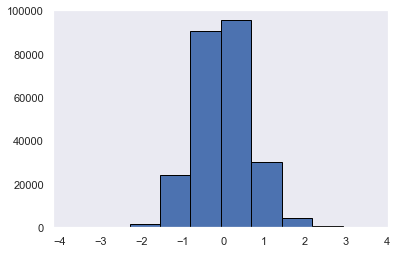

In [275]:
plt.hist(regressao.resid, edgecolor="black")

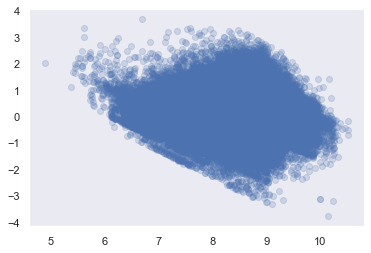

In [276]:
yhat = regressao.predict()
plt.scatter(yhat, regressao.resid, alpha=.2)

(5, 12)

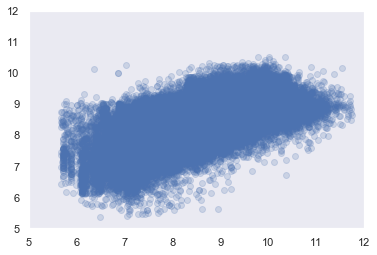

In [277]:
plt.scatter(y, yhat, alpha=.2)
plt.xlim((5, 12))
plt.ylim((5, 12))